In [44]:

# Carregando dados de exemplo

import re
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn.datasets import load_iris
import itertools

# Data set de exemplo o Cardiac desease
# Fonte: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

# Load Example Data

att_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]

data = pd.read_csv( r"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                    names = att_names )

cat_vars = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]

#data = ( data
#         .assign( **{ col : data[col].astype(str) for col in cat_vars } ) )

data['y'] = [ 0 if k == 0 else 1 for k in data['num'] ]

new_data = pd.concat( [pd.get_dummies( data['cp'], prefix = "cp", drop_first = True ),data['exang']*1, data['y']], axis = 1 )

new_data


,cp_2.0,cp_3.0,cp_4.0,exang,y
0,0,0,0,0.0,0
1,0,0,1,1.0,1
2,0,0,1,1.0,1
3,0,1,0,0.0,0
4,1,0,0,0.0,0
...,...,...,...,...,...
298,0,0,0,0.0,1
299,0,0,1,0.0,1
300,0,0,1,1.0,1
301,1,0,0,0.0,1


In [49]:
# Arvore ID3 ( Classificadora com dados categóricos )

class ID3_Tree:
    
    def __init__( self, data, X, y ):
        
        self.data = data
        self.X    = X
        self.y    = y
    
    # Calculo da entropia por variavel
    
    def entropy( self, X, y, n ):
        
        clas = list( set( X ) )
        #print( clas, len( x ), list( x ) )
        vector_class = [ [list( X )[j] == i for j in range(0, len(list( X ))) ] for i in clas ]
    
        probs = [ np.mean( list( itertools.compress( y, k ) ) ) for k in vector_class ]
    
        return { n : - np.sum( [ k*np.log2(k) for k in probs ] ) } 
    
    # 
    
    def id3_class_tree( self, data, x, y ):
        
        classes = set( data[y] )
        occur   = [ list(data[y]).count(i) for i in classes ]
        
        if len( classes ) == 1:
            
            return { 'N' : str( len(data[y]) ),
                     'v' : { item : list(data[y]).count(item) for item in set( classes ) },
                     'm' : np.mean(data[y]) }
        
        if len( x ) == 0:
            
            return { 'N' : str( len(data[y]) ),
                     'v' : { item : list(data[y]).count(item) for item in set( classes ) },
                     'm' : np.mean(data[y]) }
        
        # Ordena as variáveis com maior entropia
        
        f_ent = sorted( [ self.entropy( X = data[ i ], 
                                        y = data['y'], 
                                        n = i ) for i in x ], 
                        key = lambda x: list(x.values())[0] )
        
        ord_ent = [ list( dic.keys() )[0] for dic in f_ent ]
        
        return { str( ord_ent[0] ) : { k : 
                   self.id3_class_tree( data = data[ data[ord_ent[0]] == k ], 
                                        x = ord_ent[1:], 
                                        y = y ) for k in set( data[ ord_ent[0] ] ) } }
    
    def classifica(  self, classes : dict ):
        
        d = self.model_
        
        while 'm' not in [ k[0] for k in list( d.items() ) ]:
            
            for i,j in d.items():
                r = list( d.items() )[0]
                
                if len( j ) == 2:
                    for s in range(0, 2):
                        if classes[i] == [ k[0] for k in list( r[1].items() ) ][s]:
                            d = list( r[1].items() )[s][1]
                else :
                    d = list( r[1].items() )[0][1]
        return d['m']
    
    def fit( self, cutoff = 0.5 ):
        
        self.model_ = self.id3_class_tree( data = self.data, x = self.X, y = self.y )
        
        #print( self.model.items() )
    
        self.est_values = [ self.classifica( dict( self.data.loc[ n, self.X ] ) ) for n in range(0, len( self.data )) ]
        
        self.est_class  = [ 1 if v >= cutoff else 0 for v in self.est_values ]
        
        return self
    
    def predict( self, dp, cutoff = 0.5 ):
        
        self.predict_values = [ self.classifica( dict( dp.loc[ n, self.X] ) ) for n in range(0, len( dp ) ) ] 
        
        self.predict_class  = [ 1 if v >= cutoff else 0 for v in self.predict_values ]
        
        return self

In [71]:
class C45_Tree:
    
    def __init__( self, data, X, y ):
        
        self.data = data
        self.X    = X
        self.y    = y
        
    def gini( self, x, y, n, c, name = "", k = "" ):
        
        clas = list( set( x ) )
    
        vector_class = [ [list(x)[j] == i for j in range(0, len(list( x ))) ] for i in clas ]
    
        probs = [ np.mean( list( itertools.compress( y, k ) ) ) for k in vector_class ]
        pops  = [ len( list( itertools.compress( y, k ) ) ) for k in vector_class ]
        gini  = [ 2*k*(1-k) for k in probs ]
    
        if c == "cat":
            return { n  : np.sum([ pops[i]*gini[i] for i in range( 0, len( pops ) ) ])/np.sum(pops), 
                     'c': c } 
        
        else :
            return { n      : np.sum([ pops[i]*gini[i] for i in range( 0, len( pops ) ) ])/np.sum(pops), 
                     'c'    : c,
                     'name' : name,
                     'split': k} 
        
    def split_cont_var( self, x, y, n, c ):   
        
        set_test = sorted( set( x ) ) 
        
        if len( set_test ) == 1:
            return self.gini( x = x <= set_test[0], y = y, n = n+"<="+str(set_test[0]), c = c, name = n, k = set_test[0] )
    
        split_x  = [ np.mean([set_test[i-1], set_test[i]]) for i in range(1, len(set_test) ) ]
        ginis    = [ self.gini( x = x <= i, y = y, n = n+"<="+str(i), c = c, name = n, k = i ) for i in split_x ]
    
    
        return sorted( ginis, key = lambda x: list(x.values())[0] )[0]
    
    
    def c45_class_tree( self, data, x, y ):
    
        classes = list( set( data[y] ) )
    
        occur   = [ list(data[y]).count(i) for i in classes ]
    
        # Possiveis Condicoes para encerrar arvore:
        # 1. Todas observacoes pertecem a mesma classe ´y´;
        # 2. Nao existem mais variaveis independentes para serem usadas;
        # 3. Variaveis nao contém informacao adicional (pertecem a uma mesma classe);
    
        if len( classes ) == 1:
            
            return { 'N' : str( len(data[y]) ), 
                     'v' : { item : list(data[y]).count(item) for item in set( classes ) }, 
                     'm' : np.mean(data[y]) }
        
        if len( x ) == 0:
        
            return { 'N' : str( len(data[y]) ), 
                     'v' : { item : list(data[y]).count(item) for item in set( classes ) }, 
                     'm' : np.mean(data[y]) }
        
        if len( x ) == 1 and len( set( data[x[0]] ) ) == 1:
        
            return { 'N' : str( len(data[y]) ), 
                     'v' : { item : list(data[y]).count(item) for item in set( classes ) }, 
                     'm' : np.mean(data[y]) }
        
        if np.sum( [ len( set( data[k] ) ) for k in x ] ) == len( x ):
        
            return { 'N' : str( len(data[y]) ), 
                     'v' : { item : list(data[y]).count(item) for item in set( classes ) }, 
                     'm' : np.mean(data[y]) }
        
            
        # Pega conjunto de variaveis e ordena de acordo com maior Gini (Maior discriminacao)
        # Classifica variavel entre númerica e categorica:
        # 1. Númerica presente no intervalo de inteiros e floats com duas ou mais classes;
        # 2. Categórica apenas aponta variavel binaria (0,1);
    
        f_ent = sorted( [ self.gini( x = data[ i ], 
                                     y = data[ y ], 
                                     n = i,
                                     c = "cat") if len( set( data[i] ) ) == 2 and list( set( data[i] ) ) == [0,1]
                          else self.split_cont_var( x = data[ i ],
                                                    y = data[ y ],
                                                    n = i,
                                                    c = "num") for i in x ], 
                         key = lambda x: list(x.values())[0] )
    
        ord_ent = [ list( dic.keys() )[0] for dic in f_ent ]
    
        # Recursao referente a classificao de arvore em duas opcoes:
        # 1. Saida numérica
        # 2. Saida categorica
    
    
        if f_ent[0]["c"] == "num":
        
            return { str( ord_ent[0] ) : { k :
                        self.c45_class_tree( data = data[ ( data[f_ent[0]["name"]] <= f_ent[0]["split"] ) == k  ],
                                             x = x,
                                             y = y) for k in [True, False] }}
    
        if f_ent[0]["c"] == "cat":
        
            ord_ent_2 = [ re.findall( "^.*?(?=<=)", word )[0] if "<=" in word  else word for word in ord_ent ]
        
            return { str( ord_ent[0] ) : { k : 
                       self.c45_class_tree( data = data[ data[ord_ent[0]] == k ], 
                                            x = ord_ent_2[1:], 
                                            y = y ) for k in set( data[ ord_ent[0] ] ) } }



    def classifica( self, classes : dict ):
    
        d = self.model
    
        while 'm' not in [ k[0] for k in list( d.items() ) ]:
            for i,j in d.items():
                #print( i )
                r = list( d.items() )[0]
                if "<=" in i:
                    string_ = i.split("<=")
                    if classes[ string_[0] ] <= float( string_[1] ):
                        d = list( r[1].items() )[0][1]
                    else:
                        d = list( r[1].items() )[1][1]
                else:
                    d = list( r[1].items() )[0][1]
    
        return d['m']
    

    def fit( self, cutoff = 0.5 ):      
        self.model = self.c45_class_tree( self.data, self.X, self.y )
        
        #print( self.model )
        
        self.est_value = [ self.classifica( dict( self.data.loc[ n, self.X ] ) ) for n in range(0,len(self.data)) ]
        
        self.est_class = [ 1 if v >= cutoff else 0 for v in self.est_value ]
        
        #print( self.pred_class )
        
        return self
    
    def predict( self, dp ):
        
        self.predict_values = [ self.classifica( dict( dp.loc[ n, self.X] ) ) for n in range(0, len( dp ) ) ] 
        
        self.predict_class  = [ 1 if v >= cutoff else 0 for v in self.predict_values ]
        
        return self
    

In [80]:

import matplotlib.pyplot as plt

data_house = pd.read_excel( r'https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx',
                            sheet_name = 0 )

new_cols = [ "trans_date", "house_age", "dist_mrt_stat", "num_conv_stor", "lat", "long", "house_price" ]

data_house = ( data_house.
                  iloc[:,1:].
                  rename( { data_house.columns[1:][i] : new_cols[i] for i in range( 0, len( new_cols ) ) }, 
                          axis = "columns" ) )

data_house.describe()


,trans_date,house_age,dist_mrt_stat,num_conv_stor,lat,long,house_price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [82]:

class CART_Tree:
    
    def __init__( self, data, X, y ):
        
        self.data = data
        self.X    = X
        self.y    = y
        
    # MAE ( Mean Absolute Error )
    def mae( self, yp, y ):
        return abs( yp - y )

    # Poisson Difference
    def poisson( self, yp, y ):
        return y*np.log( y/yp ) - y + yp

    # MSE ( Mean Squared Error )
    def mse( self, yp, y ):
        return (yp - y)**2

    # Calculo ponto de quebra por meio do desvio de poisson 
    #
    # @s - Ponto de quebra da variavel continua - x
    # @x - Variavel explicativa
    # @y - Variavel Dependente

    def calc_split_poid( self, s, x, y ):
        n1, n2 = len( x[ x <= s ] ), len( x[ x > s ] )
        m1, m2 = np.mean( y[ x <= s ] ), np.mean( y[ x > s ] )
        return np.mean( np.concatenate( ([ self.poisson( m1, y[ x <= s ][i] ) for i in range(0,n1) ],
                                         [ self.poisson( m2, y[ x > s  ][i] ) for i in range(0,n2) ] ) ) )

    # Calculo ponto de quebra por meio do desvio de poisson 
    #
    # @s - Ponto de quebra da variavel continua - x
    # @x - Variavel explicativa
    # @y - Variavel Dependente

    def calc_split_mse( self, s, x, y ):
        n1, n2 = len( x[ x <= s ] ), len( x[ x > s ] )
        m1, m2 = np.mean( y[ x <= s ] ), np.mean( y[ x > s ] )
        return np.mean( np.concatenate( ([ self.mse( m1, y[ x <= s ][i] ) for i in range(0,n1) ],
                                         [ self.mse( m2, y[ x > s  ][i] ) for i in range(0,n2) ] ) ) )
     
        
        
    def get_best_split( self, x, y, name, metodo ):
        
        set_x   = sorted( list( set( x ) ) )
    
        split_x = [ np.mean( [set_x[i-1], set_x[i]] ) for i in range( 1, len( set_x ) ) ]
    
        # print( "splits length = ", len( split_x) )
    
        if metodo == "squared":
            x_best  = [ { name+"<="+str(k): self.calc_split_mse( s = k, x = np.array(x), y = np.array(y))} for k in split_x ]
        
        if metodo == "poisson":
            x_best  = [ { name+"<="+str(k): self.calc_split_poid( s = k, x = np.array(x), y = np.array(y))} for k in split_x ]
    
        return sorted( x_best, key = lambda x: list(x.values())[0] )



    # Constroi Modelo de arvore de regressao
    #
    # @data      - Pandas Data Frame com conjunto de dados
    # @x         - Lista com variaveis explicativas do modelo
    # @y         - String com variavel dependente
    # @metodo    - String sendo "squared" para metodo MSE ou "poisson" para Poisson
    # @max_depth - Maximo de iteracoes permitidas 
    # @return    - retorna um dicionario com as variaveis escolhidas, pontos de corte e resultados

    def reg_tree_model( self, data, x, y, max_depth, metodo = "squared" ):
    
        # Divisão de retorno entre
        #
        # 1.  
        # 2.
        
        if max_depth > 0 :
        
            #print( "md = ",max_depth,
            #       "rows = ", len( data[y] ) )
        
            #print( { i: len( list( set( data[i] ) ) )  for i in x } )
        
            if len( data[y] ) == 1 :
                return { 'm' : np.mean( data[y] ), 'N' : len( data[y] ) }  
        
            x_vars = list( filter( lambda k: len( set( data[k] ) )> 1, x ) )
            #print( x_vars )
        
            if len( x_vars ) == 0:
                return { 'm' : np.mean( data[y] ), 'N' : len( data[y] ) }
        
        
            best_var_splits = sorted( [ self.get_best_split( data[i], data[y], metodo = metodo, name = i )[0] for i in x_vars ],
                                      key = lambda x: list( x.values() )[0] )
        
            items = list( best_var_splits[0].keys() )[0].split("<=")
        
            #print( [ len( set( data.loc[ data[ items[0] ] <= float( items[1] ), items[0] ] ) ),
            #         len( set( data.loc[ data[ items[0] ] >  float( items[1] ), items[0] ] ) ) ] )
        
            #if len( set( data.loc[ data[ items[0] ] <= float( items[1] ), items[0] ] ) ) == 1:
            #    print( "ok" )
            #    return { 'm' : np.mean( data[y] ), 'N' : len( data[y] ) }  
            #else:
            return { "<=".join(items):
                        { True  : self.reg_tree_model( data = data[ data[items[0]] <= float(items[1]) ], 
                                                       x = x, 
                                                       y = y, 
                                                       metodo = metodo, 
                                                       max_depth = max_depth - 1 ),
                         False : self.reg_tree_model( data = data[ data[items[0]] > float(items[1]) ], 
                                                      x = x, 
                                                      y = y, 
                                                      metodo = metodo, 
                                                      max_depth = max_depth - 1 ) } }
        
        if max_depth == 0:
            return { 'm' : np.mean( data[y] ), 'N' : len( data[y] ) }
        
        
        
    def classifica( self, classes : dict ):
        
        d = self.model
        
        while 'm' not in [ k[0] for k in list( d.items() ) ]:
            for i,j in d.items():
                r = list( d.items() )[0]
                if "<=" in i:
                    string_ = i.split("<=")
                    if classes[ string_[0] ] <= float( string_[1] ):
                        d = list( r[1].items() )[0][1]
                    else:
                        d = list( r[1].items() )[1][1]
                else:
                    d = list( r[1].items() )[0][1]
    
        return d['m']
    
    def fit( self, metodo = "squared", max_depth = 5 ):
        
        self.model = self.reg_tree_model( data = self.data, x = self.X, y = self.y, metodo = metodo, max_depth = max_depth ) 
        
        self.est_values = [ self.classifica( dict( self.data.loc[ n, self.X ] ) ) for n in range(0,len( self.data )) ]
        
        return self
    
    def predict( self, dp ):
        
        self.predict_values = [ self.classifica( dict( dp.loc[ n, self.X ]) ) for n in range( 0, len( dp ) ) ]
        
        return self


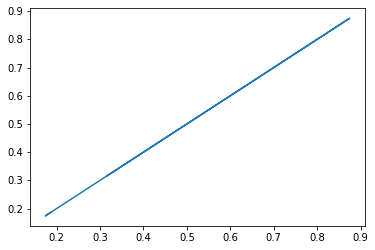

In [76]:
# Testes - ID3

# Teste usando o modelo feito a mão

arvore_id3 = ID3_Tree( data = new_data, X = ['cp_4.0','cp_3.0','cp_2.0','exang'], y = "y" ) 

arvore_id3 = arvore_id3.fit()

arvore_id3 = arvore_id3.predict( dp = new_data )

# Teste usando o pacote Scikit Learn

clf_id3 = sklearn.tree.DecisionTreeClassifier()

clf_id3 = clf_id3.fit( new_data[['cp_4.0','cp_3.0','cp_2.0','exang']], new_data[['y']] )


results_sk_id3 = clf_id3.predict_proba( new_data[['cp_4.0','cp_3.0','cp_2.0','exang'] ] )

results_sk_id3 = [ i[1] for i in results_sk_id3 ]

# Comparação dos resultados

import matplotlib.pyplot as plt

plt.plot( arvore_id3.est_values, results_sk_id3 )
plt.show( )


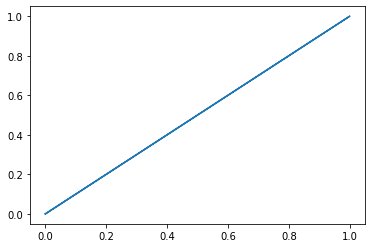

In [75]:
# Testes - C4.5

arvore_c45 = C45_Tree( data = data, X = ["trestbps","thalach"], y = "y")

arvore_c45 = arvore_c45.fit()

# Teste Usando SciKit Learn

clf_c45 = sklearn.tree.DecisionTreeClassifier()

clf_c45 = clf_c45.fit( data[["trestbps","thalach"]], new_data[["y"]] )


results_sk_c45 = clf_c45.predict_proba( data[["trestbps","thalach"] ] )

results_sk_c45 = [ i[1] for i in results_sk_c45 ]

# Comparação resultados

plt.plot( arvore_c45.est_value, results_sk_c45 )
plt.show( )


md =  5 rows =  414
md =  4 rows =  265
md =  3 rows =  90
md =  2 rows =  72
md =  1 rows =  70
md =  1 rows =  2
md =  2 rows =  18
md =  1 rows =  16
md =  1 rows =  2
md =  3 rows =  175
md =  2 rows =  65
md =  1 rows =  55
md =  1 rows =  10
md =  2 rows =  110
md =  1 rows =  52
md =  1 rows =  58
md =  4 rows =  149
md =  3 rows =  116
md =  2 rows =  77
md =  1 rows =  26
md =  1 rows =  51
md =  2 rows =  39
md =  1 rows =  37
md =  1 rows =  2
md =  3 rows =  33
md =  2 rows =  31
md =  1 rows =  27
md =  1 rows =  4
md =  2 rows =  2
md =  1 rows =  1
md =  1 rows =  1


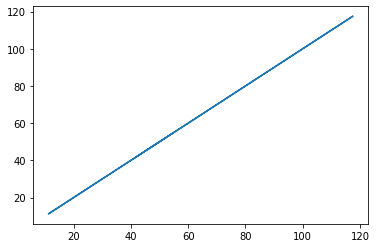

In [90]:
# Testes - CART (Regression Tree)

arvore_cart = CART_Tree( data = data_house, 
                         X = ['house_age','num_conv_stor','dist_mrt_stat'], 
                         y = "house_price" )

arvore_cart = arvore_cart.fit( )

# Teste usando SciKit Learn

clf_cart = sklearn.tree.DecisionTreeRegressor( max_depth = 5 )

clf_cart = clf_cart.fit( data_house[['house_age','num_conv_stor','dist_mrt_stat']], data_house[["house_price"]] )

results_clf_cart = clf_cart.predict( data_house[['house_age','num_conv_stor','dist_mrt_stat']] )


plt.plot( arvore_cart.est_values ,results_clf_cart )
plt.show( )


In [88]:
results_clf_cart

array([ 41.55714286,  48.705     ,  39.8875    ,  39.8875    ,
        46.43571429,  26.98297872,  39.8875    ,  48.705     ,
        18.1       ,  24.45555556,  35.42258065,  54.73181818,
        39.8875    ,  24.45555556,  30.77619048,  39.8875    ,
        54.73181818,  39.53809524,  39.53809524,  54.73181818,
        26.98297872,  54.73181818,  30.77619048,  54.73181818,
        35.42258065,  24.45555556,  49.38461538,  49.38461538,
        39.8875    ,  46.43571429,  16.21111111,  39.8875    ,
        35.42258065,  48.705     ,  41.55714286,  18.24444444,
        26.98297872,  30.77619048,  46.43571429,  48.705     ,
        18.24444444,  16.21111111,  39.8875    ,  39.8875    ,
        54.45      ,  35.42258065,  35.42258065,  39.8875    ,
        16.21111111,  16.21111111,  39.8875    ,  18.64      ,
        18.64      ,  39.8875    ,  48.705     ,  18.64      ,
        39.53809524,  54.73181818,  23.65      ,  39.53809524,
        26.98297872,  54.73181818,  26.98297872,  54.45